In [4]:
from langgraph.graph import StateGraph, START, END
from typing import Literal, TypedDict
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import os
load_dotenv()
from typing import Optional

In [5]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.2,
    top_p=0.1,
    max_tokens=1200,
    api_key=OPENAI_API_KEY
)

In [18]:
from typing import Optional


class IntentAgent(BaseModel):

    passage: str = Field(..., description="The passage to classify the intent for.", min_length=3)
    user_query: str = Field(..., description="The user query to classify the intent for.", min_length=3)
    output: Optional[str] = Field(None, description="The output of the intent classification.", min_length=3)


class IntentAgentResponse(BaseModel):
    intent: Literal["reading_comprehension", "verbal_ability", "critical_reasoning", "exam_mind_simulator", "option_elimination", "preparation_strategy", "general_help", "mock_test"]
    difficulty_level: Literal["easy", "medium", "hard"]

In [19]:
def classify_intent_node(state: IntentAgent):
    # prompts 
    intent_classifier_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """You are an expert CAT VARC intent classifier. 
            Analyze the student's query and classify it into one of these categories:
            - reading_comprehension: Questions about RC passages, strategies, comprehension
            - verbal_ability: Grammar, vocabulary, sentence correction, para jumbles
            - critical_reasoning: Logical reasoning, assumptions, conclusions, arguments
            - exam_mind_simulator: Simulating examiner's mind, question design, psychological traps
            - option_elimination: Strategies for eliminating options, decision-making, confusing options
            - preparation_strategy: Study plans, time management, resources
            - general_help: Study plans, motivation, general CAT advice
            - mock_test: Practice tests, mock exams, timed practice
            from the {passage} provided, extract the intent category.
            Also extract:
            - current_topic: Specific topic within the category
            - difficulty_level: 1 (beginner) to 5 (expert)
            """),
        ("human", "{user_query}"),
    ]
)
    messages = intent_classifier_prompt.format_messages(
        passage = state.passage,
        user_query = state.user_query
    )
    structured_model = model.with_structured_output(IntentAgentResponse)
    response = structured_model.invoke(messages)
    state.output = response
    # return {"response":state['output']}
    return state

In [20]:
graph = StateGraph(IntentAgent)

# nodes
graph.add_node('classify_intent',classify_intent_node)

# edges
graph.add_edge(START, 'classify_intent')
graph.add_edge('classify_intent', END)

# compile
workflow = graph.compile()


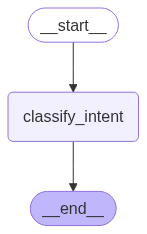

In [21]:
workflow

In [22]:
initial_state = {
    "passage":"""[T]he idea of craftsmanship is not simply nostalgic. . . . Crafts require distinct skills, an all-round approach to work that involves the whole product, rather than individual parts, and an attitude that necessitates devotion to the job and a focus on the communal interest. The concept of craft emphasises the human touch and individual judgment.

    Essentially, the crafts concept seems to run against the preponderant ethos of management studies which, as the academics note, have long prioritised efficiency and consistency. . . . Craft skills were portrayed as being primitive and traditionalist.

    The contrast between artisanship and efficiency first came to the fore in the 19th century when British manufacturers suddenly faced competition from across the Atlantic as firms developed the "American system" using standardised parts. . . . the worldwide success of the Singer sewing machine showed the potential of a mass-produced device. This process created its own reaction, first in the form of the Arts and Crafts movement of the late 19th century, and then again in the "small is beautiful" movement of the 1970s. A third crafts movement is emerging as people become aware of the environmental impact of conventional industry.

    There are two potential markets for those who practise crafts. The first stems from the existence of consumers who are willing to pay a premium price for goods that are deemed to be of extra quality. . . . The second market lies in those consumers who wish to use their purchases to support local workers, or to reduce their environmental impact by taking goods to craftspeople to be mended, or recycled.

    For workers, the appeal of craftsmanship is that it allows them the autonomy to make creative choices, and thus makes a job far more satisfying. In that sense, it could offer hope for the overall labour market. Let the machines automate dull and repetitive tasks and let workers focus purely on their skills, judgment and imagination. As a current example, the academics cite the "agile" manifesto in the software sector, an industry at the heart of technological change. The pioneers behind the original agile manifesto promised to prioritise "individuals and interactions over processes and tools". By bringing together experts from different teams, agile working is designed to improve creativity.

    But the broader question is whether crafts can create a lot more jobs than they do today. Demand for crafted products may rise but will it be easy to retrain workers in sectors that might get automated (such as truck drivers) to take advantage? In a world where products and services often have to pass through regulatory hoops, large companies will usually have the advantage.

    History also suggests that the link between crafts and creativity is not automatic. Medieval craft guilds were monopolies which resisted new entrants. They were also highly hierarchical with young men required to spend long periods as apprentices and journeymen before they could set up on their own; by that time the innovative spirit may have been knocked out of them. Craft workers can thrive in the modern era, but only if they don't get too organised.""",

    "user_query":""" We can infer from the passage that medieval crafts guilds resembled mass production in that both
        options:
        A) discouraged innovation by restricting entry through strict rules.
        B) focused excessively on product quality.
        C) did not necessarily promote creativity.
        D) did not always employ egalitarian production processes.

        how to solve this question based on the passage, give me step by step . Give me correct answer and explanation."""
}

final_state = workflow.invoke(initial_state)

In [23]:
final_state

{'passage': '[T]he idea of craftsmanship is not simply nostalgic. . . . Crafts require distinct skills, an all-round approach to work that involves the whole product, rather than individual parts, and an attitude that necessitates devotion to the job and a focus on the communal interest. The concept of craft emphasises the human touch and individual judgment.\n\n    Essentially, the crafts concept seems to run against the preponderant ethos of management studies which, as the academics note, have long prioritised efficiency and consistency. . . . Craft skills were portrayed as being primitive and traditionalist.\n\n    The contrast between artisanship and efficiency first came to the fore in the 19th century when British manufacturers suddenly faced competition from across the Atlantic as firms developed the "American system" using standardised parts. . . . the worldwide success of the Singer sewing machine showed the potential of a mass-produced device. This process created its own re

In [6]:
class CriticalAgentResponse(BaseModel):
    intent_critical: Literal[
    "Explain",]
    difficulty_level: Literal["easy", "medium", "hard"]


class CriticalAgentState(TypedDict, total = False):
    passage: str
    user_query: str
    intent_metadata: CriticalAgentResponse

    # conclusion_response: str
    # implication_response: str
    # infer_strongly_supported_response: str
    # infer_dispute_response: str
    # identify_technique_response: str
    # role_response: str
    # principle_response: str
    # structure_response: str
    # flaw_response: str
    # match_flaws_response: str
    # necessary_assumptions_response: str
    # sufficient_assumptions_response: str
    # strengthen_response: str
    # weaken_response: str
    # most_least_helpful_response: str
    explain_response: str
    # resolve_conflict_response: str

In [7]:
def classify_critical_reasoning_intent_node(state: CriticalAgentState):
    critical_reasoning_intent_prompt = ChatPromptTemplate.from_messages([
       ("system", """You are an expert CAT VARC critical reasoning intent classifier. 
            Analyze the student's query and classify it into one of these categories:
            
            Explain
            {passage}
            """),
        ("human", "{user_query}"),
    ])
    messages = critical_reasoning_intent_prompt.format_messages(
        passage = state['passage'],
        user_query = state['user_query']
    )
    structured_model = model.with_structured_output(CriticalAgentResponse)
    response = structured_model.invoke(messages)
    # Return dict with the key to update in state
    print(f"📋 Classified Intent: {response.intent_critical} (difficulty: {response.difficulty_level})")
    # return {"intent_metadata": response}
    return {"intent_metadata": response}

In [8]:
def explain_agent_node(state: CriticalAgentState):
    intent_data = state['intent_metadata']
    # prompts
    explain_agent_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the world's leading expert in logical reasoning for CAT VARC Explain/Resolve questions 
    Examples:
    Each of the following, if true, contributes to an explanation of the difference in caloric intake EXCEPT:
    Which one of the following, if true, most helps to explain the apparently paradoxical result?
    Which one of the following, if true, most helps to explain the failure of the strategy?
    Which one of the following, if true, most helps to explain the preference described above?
    
    Explanation: Top tip Sometimes students see the words “helps to” in an explain question and they mistake it for a strengthen question. Notice, however, that in explain question types, you’re not helping an argument (which is what a strengthen question asks you to do), but that you’re helping to explain how a situation could have occurred.

    Provide SYSTEMATIC EXPLANATION ANALYSIS:

    1. **Identify the puzzling situation:**
    - Restate the surprising or contradictory facts in your own words
    - Pinpoint why it is unexpected or paradoxical
    - Detect any contrast keywords (however, yet, but, surprising, paradoxically)

    2. **Formulate the central question:**
    - Turn the paradox/surprise into a clear question
    - Example: “Why did X happen even though Y should have prevented it?”

    3. **Evaluate each option logically:**
    - Add the option’s information to the situation
    - Does it shed light on the paradox? (Yes = explains, No = irrelevant)
    - Does it make the situation more puzzling? (If yes, eliminate immediately)
    - Judge relevance, explanatory power, and fit with given facts

    4. **Common wrong choice traps:**
    - **Irrelevant detail:** Looks fact-like but doesn’t address the paradox
    - **Opposite effect:** Makes the paradox sharper or more confusing
    - **Background filler:** True fact but neutral, does not explain anything
    - **Too general/obvious:** States something already implied without resolving gap

    5. **Final logical conclusion:**
    - Which option BEST explains the puzzling situation
    - Why other options fail (irrelevant, opposite, filler, general)
    - Degree of logical certainty (1–10)

    Provide EXAMPLES for clarity:

    Example Stimulus:
    Populations of a shrimp species at Indonesian coral reefs show substantial genetic differences, even though strong ocean currents should mix populations.

    Question:
    Which one of the following, if true, most helps to explain the substantial genetic differences?

    Choose 1 answer:
    (Choice A, Incorrect)   The genetic differences between the shrimp populations are much less significant than those between shrimp and any other marine species.
    The genetic differences between the shrimp populations are much less significant than those between shrimp and any other marine species.
    This comparison doesn’t help explain the situation about shrimp, because what’s true for other marine species isn’t necessarily true for shrimp.
    (Choice B, Incorrect)   The individual shrimp within a given population at any given Indonesian coral reef differ from one another genetically, even though there is widespread interbreeding within any such population.
    The individual shrimp within a given population at any given Indonesian coral reef differ from one another genetically, even though there is widespread interbreeding within any such population.
    This isn’t helpful to us. Information that individual shrimp are genetically different from each other at any given reef doesn’t help us answer the question, “Why are the shrimp genetically different from reef to reef?”
    (Choice C, Checked, Correct)   Before breeding, shrimp of the species examined migrate back to the coral reef at which they were hatched.
    Before breeding, shrimp of the species examined migrate back to the coral reef at which they were hatched.
    This information helps explain why the shrimp are genetically different. While the shrimp might be carried among the reefs by strong currents, as the passage indicates is possible, this choice indicates that the shrimp return to the reef where they were hatched before breeding. So, even though the conditions are such that the shrimp could interbreed, this choice explains why they don’t.
    (Choice D, Incorrect)   Most shrimp hatched at a given Indonesian coral reef are no longer present at that coral reef upon becoming old enough to breed.
    Most shrimp hatched at a given Indonesian coral reef are no longer present at that coral reef upon becoming old enough to breed.
    This information could actually make the passage more surprising. This choice confirms that most shrimp hatched at a given reef leave that reef to breed, so we have even more reason to believe that interbreeding would happen. Yet the effect of interbreeding (genetic similarities) isn’t happening.
    (Choice E, Incorrect)   Ocean currents probably carry many of the baby shrimp hatched at a given Indonesian coral reef out into the open ocean rather than to another coral reef.
    Ocean currents probably carry many of the baby shrimp hatched at a given Indonesian coral reef out into the open ocean rather than to another coral reef.
    This choice doesn’t help explain the situation. We aren’t trying to figure out why there’s a genetically diverse population of shrimp in the open ocean; we’re trying to figure out why the shrimp are genetically different from reef to reef.

    Psychological Traps:
    - Students often pick (A) because it “sounds scientific” but doesn’t address puzzle
    - Many pick (B) because it feels relevant, but it’s only background filler

    NEXT STEP RECOMMENDATION:
    Always phrase the paradox as a “Why” question, then test each choice as a possible answer. Eliminate options that don’t reduce the puzzlement.
    {passage}"""),
    ("human", "{query}")
])
    messages = explain_agent_prompt.format_messages(

    passage=state['passage'],
    query=state['user_query'],
    intent_critical=intent_data.intent_critical,
    difficulty=intent_data.difficulty_level

    )
    response = model.invoke(messages).content
    return {"explain_response": response}

In [16]:
graph = StateGraph(CriticalAgentState)

# nodes
graph.add_node('classify_intent',classify_critical_reasoning_intent_node)
graph.add_node('explain',explain_agent_node)

# edges
graph.add_edge(START, 'classify_intent')
graph.add_edge('classify_intent', 'explain')
graph.add_edge('explain', END)

# compile
workflow = graph.compile()


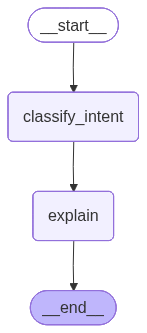

In [17]:
workflow

In [24]:
initial_state = {
        "passage": """(. . .) There are three other common drivers for carnivore-human attacks, some of which are more preventable than others. Natural aggression-based conflicts – such as those involving females protecting their young or animals protecting a food source – can often be avoided as long as people stay away from those animals and their food.
        Carnivores that recognise humans as a means to get food, are a different story. As they become more reliant on human food they might find at campsites or in rubbish bins, they become less avoidant of humans. Losing that instinctive fear response puts them into more situations where they could get into an altercation with a human, which often results in that bear being put down by humans. "A fed bear is a dead bear," says Servheen, referring to a common saying among biologists and conservationists.
        Predatory or predation-related attacks are quite rare, only accounting for 17% of attacks in North America since 1955. They occur when a carnivore views a human as prey and hunts it like it would any other animal it uses for food. (. . .)

        Then there are animal attacks provoked by people taking pictures with them or feeding them in natural settings such as national parks which often end with animals being euthanised out of precaution. "Eventually, that animal becomes habituated to people, and [then] bad things happen to the animal. And the folks who initially wanted to make that connection don't necessarily realise that," says Christine Wilkinson, a postdoctoral researcher at UC Berkeley, California, who's been studying coyote-human conflicts.

        After conducting countless postmortems on all types of carnivore-human attacks spanning 75 years, Penteriani's team believes 50% could have been avoided if humans reacted differently. A 2017 study co-authored by Penteriani found that engaging in risky behaviour around large carnivores increases the likelihood of an attack.
        Two of the most common risky behaviours are parents leaving their children to play outside unattended and walking an unleashed dog, according to the study. Wilkinson says 66% of coyote attacks involve a dog. "[People] end up in a situation where their dog is being chased, or their dog chases a coyote, or maybe they're walking their dog near a den that's marked, and the coyote wants to escort them away," says Wilkinson.

        Experts believe climate change also plays a part in the escalation of human-carnivore conflicts, but the correlation still needs to be ironed out. "As finite resources become scarcer, carnivores and people are coming into more frequent contact, which means that more conflict could occur," says Jen Miller, international programme specialist for the US Fish & Wildlife Service. For example, she says, there was an uptick in lion attacks in western India during a drought when lions and people were relying on the same water sources.

        (. . .) The likelihood of human-carnivore conflicts appears to be higher in areas of low-income countries dominated by vast rural landscapes and farmland, according to Penteriani's research. "There are a lot of working landscapes in the Global South that are really heterogeneous, that are interspersed with carnivore habitats, forests and savannahs, which creates a lot more opportunity for these encounters, just statistically," says Wilkinson.

        """,

        "user_query":"""   
        Which of the following statements, if false, would be inconsistent with the concerns raised in the passage regarding the drivers of carnivore-human conflicts?
        options:
        A) Climate change has had negligible effects on the frequency of carnivore-human interactions in affected regions.
        B) Carnivores lose their instinctive fear of humans when consistently exposed to human food sources.
        C) Predatory attacks by carnivores are a common occurrence and have steadily increased over the past few decades.
        D) Human efforts to avoid risky behaviors around large carnivores have proven effective in reducing conflict incidents.


                """
    }
final_state = workflow.invoke(initial_state)
print(final_state.keys())
print(final_state['intent_metadata'])


📋 Classified Intent: Explain (difficulty: medium)
dict_keys(['passage', 'user_query', 'intent_metadata', 'explain_response'])
intent_critical='Explain' difficulty_level='medium'


In [25]:
print(final_state['explain_response'])

To tackle the question systematically, we will follow the outlined steps for analyzing the passage and the options provided.

### 1. **Identify the puzzling situation:**
- The passage discusses various drivers of carnivore-human conflicts, including climate change, human behaviors, and the habituation of carnivores to humans.
- The concern is that certain factors contribute to an increase in these conflicts, and if any of the statements are false, they would contradict the concerns raised in the passage.

### 2. **Formulate the central question:**
- The central question can be framed as: “What statement, if false, would contradict the concerns about the factors leading to increased carnivore-human conflicts?”

### 3. **Evaluate each option logically:**
- **Option A:** "Climate change has had negligible effects on the frequency of carnivore-human interactions in affected regions."
  - If this statement is false, it implies that climate change does have significant effects, which aligns 